     resolution card  accuracy
0           300   2S       1.0
1           300   6C       1.0
2           300   9S       1.0
3           300  10D       1.0
4           300  10H       1.0
..          ...  ...       ...
135           2   9S       0.0
136           2  10D       0.0
137           2  10H       0.0
138           2   2D       0.0
139           2   AS       0.0

[140 rows x 3 columns]


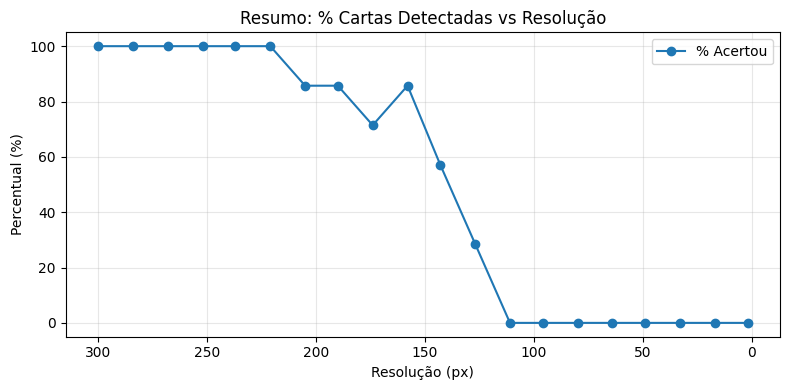

In [6]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ultralytics import YOLO
import logging
logging.getLogger("ultralytics").setLevel(logging.WARNING)
# Letterbox helper
def letterbox(img, new_shape=(640, 640), color=(114, 114, 114)):
    h, w = img.shape[:2]
    r = min(new_shape[0] / h, new_shape[1] / w)
    nh, nw = int(h * r), int(w * r)
    img_resized = cv2.resize(img, (nw, nh), interpolation=cv2.INTER_LINEAR)
    dh, dw = new_shape[0] - nh, new_shape[1] - nw
    top, bottom = dh // 2, dh - dh // 2
    left, right = dw // 2, dw - dw // 2
    return cv2.copyMakeBorder(img_resized, top, bottom, left, right,
                              cv2.BORDER_CONSTANT, value=color)

# Configuração
BASE_DIR = "imgs"
MODEL_PATH = "best.pt"
CONF_THRESH = 0.1

model = YOLO(MODEL_PATH)
files = ["2S.jpg", "6C.jpg", "9S.png", "10D.jpg", "10H.jpg", "2D.jpg", "AS.png"]

resolutions = np.linspace(300, 2, 20, dtype=int)

records = []
for res in resolutions:
    for fname in files:
        true_label = os.path.splitext(fname)[0]
        img_path = os.path.join(BASE_DIR, fname)
        img = cv2.imread(img_path)

        if img is None:
            print(f"Aviso: Não foi possível ler a imagem {img_path}")
            continue

        img_lb = letterbox(img, new_shape=(res, res))

        successes = []
        for _ in range(5):
            out = model(img_lb)[0]
            preds = [model.names[int(b.cls[0])]
                     for b in out.boxes
                     if float(b.conf[0]) >= CONF_THRESH]

            successes.append(int(true_label in preds))

        records.append({
            "resolution": res,
            "card": true_label,
            "accuracy": np.mean(successes)
        })

df = pd.DataFrame(records)
print(df)

# Agrega acurácia média para cada resolução
agg = df.groupby("resolution")["accuracy"].mean().reset_index()
agg["pct_correct"] = agg["accuracy"] * 100
agg["pct_wrong"] = (1 - agg["accuracy"]) * 100

# Plot do resultado
plt.figure(figsize=(8, 4))
plt.plot(agg["resolution"], agg["pct_correct"], marker='o', label="% Acertou")
plt.xlabel("Resolução (px)")
plt.ylabel("Percentual (%)")
plt.title("Resumo: % Cartas Detectadas vs Resolução")
plt.gca().invert_xaxis()
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
